# Automatic Differentiation in Practice (Python / PyTorch)

This notebook illustrates the ideas from Section 2.1 on Automatic Differentiation (AD):

- We visualize a scalar function and its derivative computed by AD.
- We compare an analytic gradient with an AD-computed gradient for a multivariate function.
- We compare the computational cost of finite-difference gradients vs.\ reverse-mode AD as the dimension grows.

All figures are saved into the local `figs/` directory so that they can be included in the book.

In [1]:
import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch

print("PyTorch version:", torch.__version__)

# Make sure we have a place for figures
os.makedirs("figs", exist_ok=True)

PyTorch version: 2.2.2


Saved figure: figs/AD_1D_function_and_derivative.png


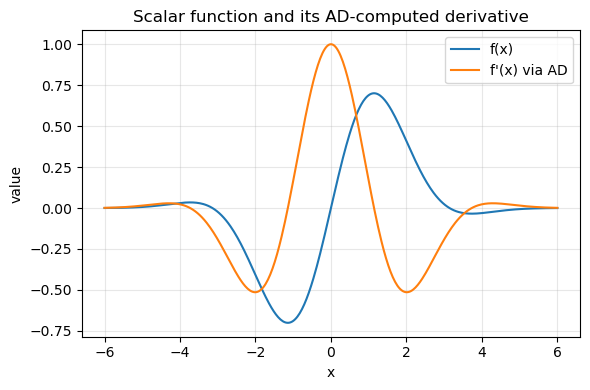

In [2]:
# -------------------------------------------------------------------
# Example 1: 1D function and its derivative via AD
# -------------------------------------------------------------------
# f(x) = sin(x) * exp(-x^2 / 5)
def f_scalar(x):
    return torch.sin(x) * torch.exp(-x**2 / 5.0)

xs = torch.linspace(-6.0, 6.0, 400)
xs.requires_grad_(True)

ys = f_scalar(xs)

# Compute derivative via reverse-mode AD
grad_outputs = torch.ones_like(ys)
ys.backward(grad_outputs)
dfdx = xs.grad.detach()

# Detach for plotting
xs_np = xs.detach().numpy()
ys_np = ys.detach().numpy()
dfdx_np = dfdx.numpy()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(xs_np, ys_np, label="f(x)")
ax.plot(xs_np, dfdx_np, label="f'(x) via AD")
ax.set_xlabel("x")
ax.set_ylabel("value")
ax.set_title("Scalar function and its AD-computed derivative")
ax.grid(alpha=0.3)
ax.legend()

fig.tight_layout()
fig_path = os.path.join("figs", "AD_1D_function_and_derivative.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved figure:", fig_path)

plt.show()

# Clear gradient for safety
xs.grad = None

## Example 2: Multivariate function and gradient check

We now consider the function
\[
k(x,y,z) = x^2 y + y z + z^3
\]
and compare:

- the analytic gradient, and  
- the gradient computed via PyTorch's reverse-mode AD.


In [3]:
# -------------------------------------------------------------------
# Example 2: multivariate function and AD vs analytic gradient
# -------------------------------------------------------------------
def k_func(vec):
    x, y, z = vec[0], vec[1], vec[2]
    return x**2 * y + y * z + z**3

# Example point
x0 = torch.tensor(1.0, requires_grad=True)
y0 = torch.tensor(2.0, requires_grad=True)
z0 = torch.tensor(3.0, requires_grad=True)

vec = torch.stack([x0, y0, z0])
val = k_func(vec)

# Compute gradient via AD
val.backward()
grad_ad = torch.stack([x0.grad, y0.grad, z0.grad])

# Analytic gradient:
# ∂k/∂x = 2 x y
# ∂k/∂y = x^2 + z
# ∂k/∂z = y + 3 z^2
grad_analytic = torch.tensor([
    2.0 * x0.detach() * y0.detach(),
    x0.detach()**2 + z0.detach(),
    y0.detach() + 3.0 * z0.detach()**2,
])

print("Point (x,y,z) =", (x0.item(), y0.item(), z0.item()))
print("Analytic gradient: ", grad_analytic.numpy())
print("AD gradient      : ", grad_ad.detach().numpy())

Point (x,y,z) = (1.0, 2.0, 3.0)
Analytic gradient:  [ 4.  4. 29.]
AD gradient      :  [ 4.  4. 29.]


## Example 3: Runtime comparison – finite differences vs reverse-mode AD

We compare the cost of computing the gradient of a scalar function
\[
g(x) = \sum_{i=1}^d \big( \sin(x_i) + 0.1 x_i^2 \big),
\]
either by:

- naive finite differences (one forward evaluation per coordinate), or  
- PyTorch reverse-mode AD (one backward pass).

We vary the dimension \(d\) and plot the resulting runtimes.

dims:       [4, 8, 16, 32, 64, 128, 256]
t_fd (s):   [0.011921, 0.001152, 0.002072, 0.003449, 0.006798, 0.013626, 0.020465]
t_ad (s):   [0.001595, 0.000377, 0.000264, 0.000194, 0.000238, 0.000267, 0.000166]
Saved figure: figs/AD_runtime_comparison.png


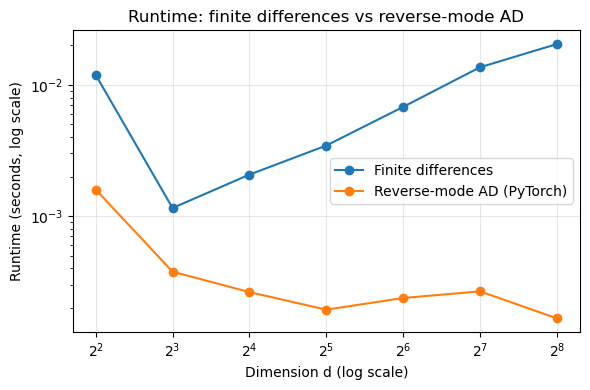

In [4]:
# -------------------------------------------------------------------
# Example 3: runtime scaling
# -------------------------------------------------------------------
def g_func(x):
    # x: torch tensor of shape (d,)
    return torch.sin(x).sum() + 0.1 * (x**2).sum()

def finite_diff_grad(fn, x, eps=1e-4):
    d = x.shape[0]
    grad = torch.zeros_like(x)
    f0 = fn(x).item()
    for i in range(d):
        x_pert = x.clone()
        x_pert[i] += eps
        fi = fn(x_pert).item()
        grad[i] = (fi - f0) / eps
    return grad

dims = [4, 8, 16, 32, 64, 128, 256]
times_fd = []
times_ad = []

for d in dims:
    x = torch.randn(d, requires_grad=True)

    # Finite differences
    start = time.perf_counter()
    grad_fd = finite_diff_grad(g_func, x)
    t_fd = time.perf_counter() - start
    times_fd.append(t_fd)

    # Reverse-mode AD
    x2 = torch.randn(d, requires_grad=True)
    start = time.perf_counter()
    y = g_func(x2)
    y.backward()
    grad_ad2 = x2.grad
    t_ad = time.perf_counter() - start
    times_ad.append(t_ad)

    # Reset grad
    x2.grad = None

print("dims:      ", dims)
print("t_fd (s):  ", [round(t, 6) for t in times_fd])
print("t_ad (s):  ", [round(t, 6) for t in times_ad])

# Plot runtime comparison
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dims, times_fd, marker="o", label="Finite differences")
ax.plot(dims, times_ad, marker="o", label="Reverse-mode AD (PyTorch)")
ax.set_xscale("log", base=2)
ax.set_yscale("log")
ax.set_xlabel("Dimension d (log scale)")
ax.set_ylabel("Runtime (seconds, log scale)")
ax.set_title("Runtime: finite differences vs reverse-mode AD")
ax.grid(alpha=0.3)
ax.legend()

fig.tight_layout()
fig_path = os.path.join("figs", "AD_runtime_comparison.png")
fig.savefig(fig_path, dpi=200, bbox_inches="tight")
print("Saved figure:", fig_path)

plt.show()